In [28]:
import pandas as pd
import numpy as np
from plotnine import ggplot, geom_bar, aes, facet_wrap
from datar.all import fct_lump_n
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns

# 1) Dados
Para esse exercício, será necessário carregar alguns dados sobre violência policial letal nos Estados Unidos:

In [2]:
link = 'https://raw.githubusercontent.com/FLS-6497/datasets/main/aula3/PKAP_raw_data.csv'
c = pd.read_csv(link, encoding='latin1')

# a) Exploração de features
Faça gráficos de barras com a frequência da variável race por cada uma das variáveis officer_ na base de dados. O resultado deve indicar quantas vítimas de mortes por violência letal policial de diferentes raças (whites e blacks) ocorreram em diferentes categorias (e.g., office_offduty). Dica: algumas variáveis precisam ser recategorizadas porque possuem muitas categorias com poucas ocorrências.

In [3]:
officer_ = [col for col in c if col.startswith('officer_') or col == 'race'] # seleciona apenas colunas com padrão officer_ ou coluna 'race'
c_officer = c[officer_]

In [4]:
# reclassificação das variaveis officer_
c_officer_adj = c_officer.copy()

c_officer_adj['officer_present'] = np.where(c_officer_adj.officer_present == 'Unknown', 'Unknown', 'Provided')

c_officer_adj['officer_fire'] = np.where(c_officer_adj.officer_fire == 'Unknown', 'Unknown', 'Provided')

c_officer_adj['officer_gender'] = c_officer_adj.officer_gender.fillna('Unknown')
c_officer_adj['officer_gender'] = np.where(c_officer_adj.officer_gender.str.contains('Male'), 'Male', c_officer_adj.officer_gender)
c_officer_adj['officer_gender'] = np.where(c_officer_adj.officer_gender.str.contains('Female'), 'Female', c_officer_adj.officer_gender)
c_officer_adj['officer_gender'] = np.where(c_officer_adj.officer_gender.str.contains('Unknown'), 'Unknown', c_officer_adj.officer_gender)

c_officer_adj['officer_race'] = (
    np.where(
        (c_officer_adj.officer_race != 'White') & 
        (c_officer_adj.officer_race != 'Black'), 
        'Others', 
        c_officer_adj.officer_race
        )
        )

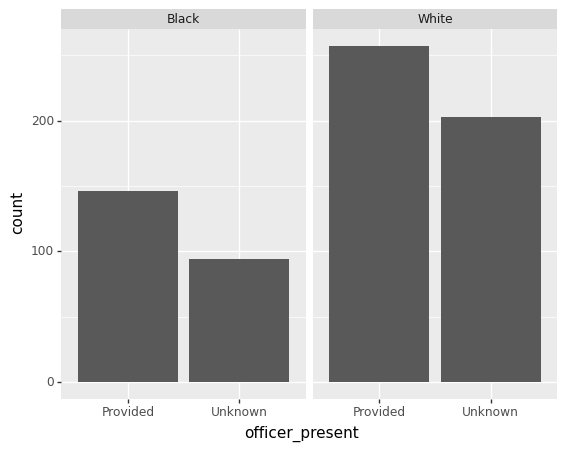

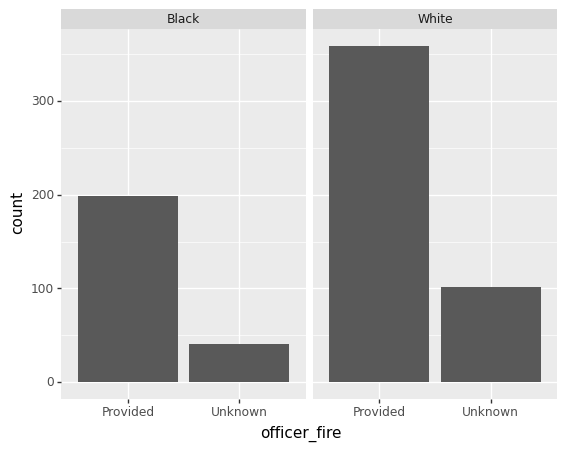

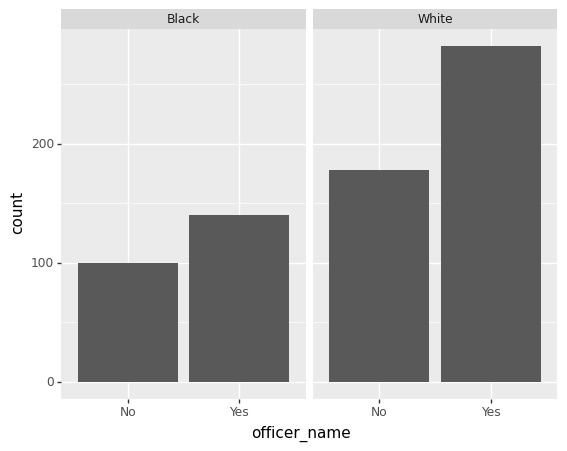

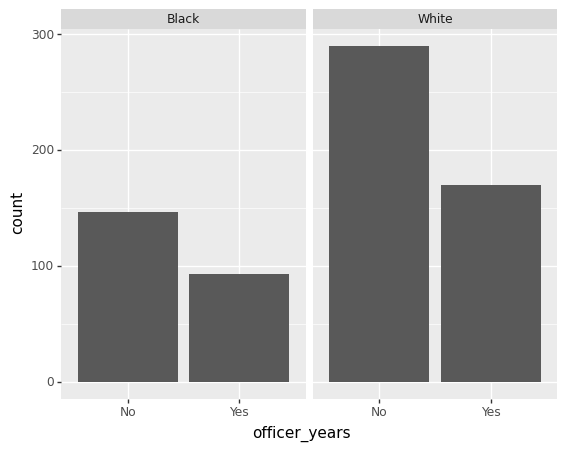

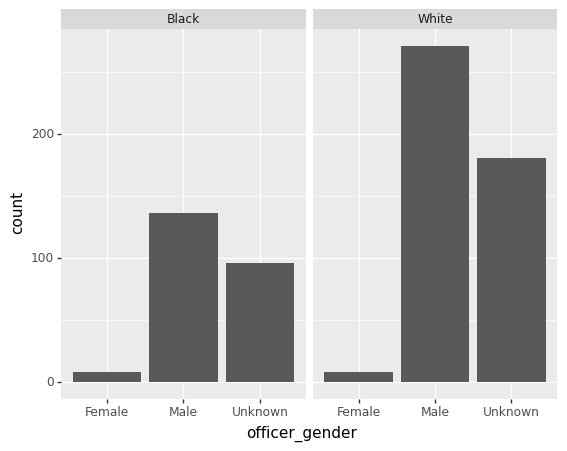

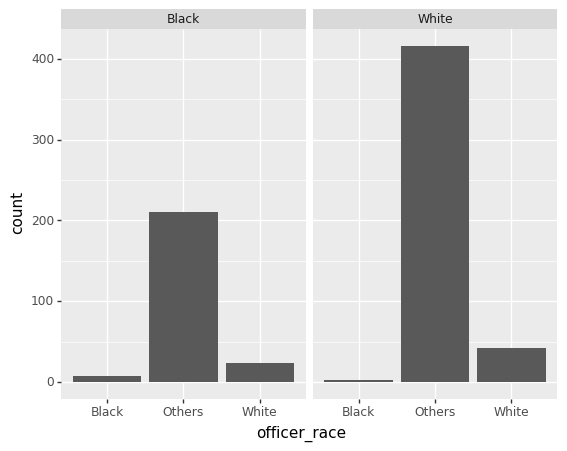

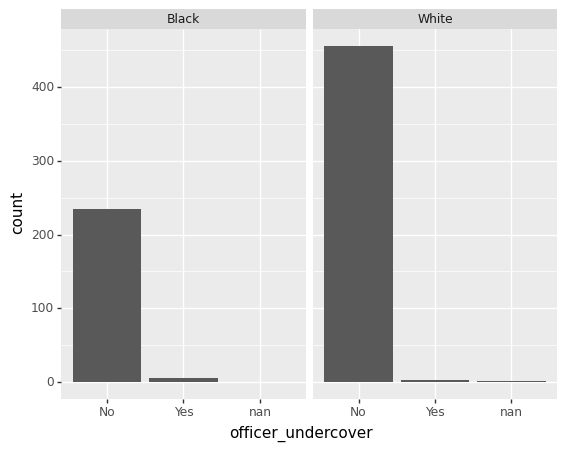

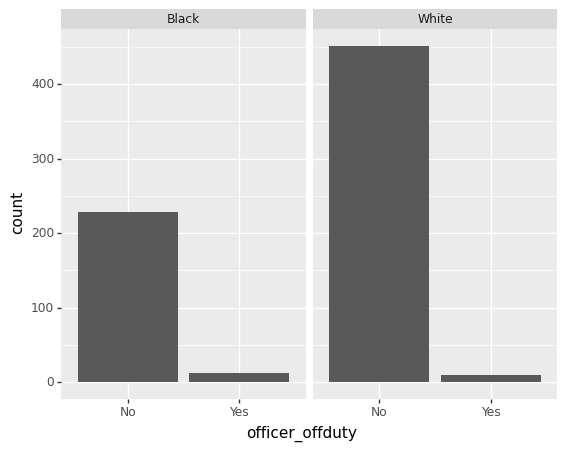

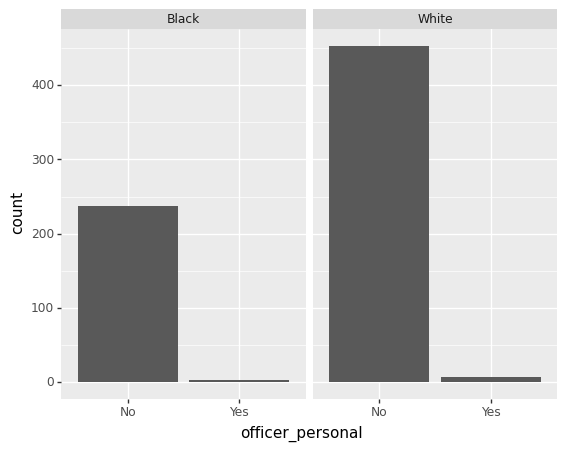

In [5]:
for column in c_officer_adj.columns:
    if (column != 'race'):
        print(
            ggplot(c_officer_adj, aes(column)) 
            + geom_bar() 
            + facet_wrap('~ race')
            )

# b) Nova base
Crie uma nova base de dados que inclua apenas as variáveis mencionadas na Tabela 1 do paper de Streeter. Dica: será necessário criar novas variáveis e descartar outras existentes na base. Para quem usa Python, também é importante recodificar variáveis para o formato de one hot encoding (em R, a maioria das funções de regressão já faz essa conversão por baixo dos panos).

In [6]:
c['reason_contact_adj'] = c.reason_contact >> fct_lump_n(3)

In [7]:
c['officer_gender'] = np.where(c.officer_gender.str.contains('Male'), 'Male', c.officer_gender)

In [8]:
c['time_of_day'] = np.where(c.time.str.contains('PM'), 'PM', 'AM')

In [9]:
c['location_adj'] = c.location >> fct_lump_n(3)

In [10]:
c['armed_adj'] = c.armed >> fct_lump_n(3)

In [11]:
c['non_compliance_adj'] = c.non_compliance >> fct_lump_n(3)

In [12]:
c['officer_race_adj'] = c.officer_race >> fct_lump_n(3)

In [13]:
c['swat_adj'] = np.where(c.swat == 'Yes', 1, 0)

In [14]:
c['crime_adj'] = c.crime >> fct_lump_n(3)

In [15]:
c['criminal_rec_adj'] = np.where(c.criminal_rec == 'Yes', 1, 0)

In [16]:
c['violent_rec_adj'] = np.where(c.violent_rec == 'Yes', 1, 0)

In [17]:
c['mental_adj'] = np.where(c.mental == 'Yes', 1, 0)

In [18]:
# unarmed? endangering civilians? chemical spray? taser? married?
c_adj = c[['location_adj', 'witness', 'reason_contact_adj', 'time_of_day', 'armed_adj', 
'non_compliance_adj', 'officer_race_adj', 'swat_adj', 'crime_adj',
'criminal_rec_adj', 'violent_rec_adj', 'age', 'gender', 'mental_adj']]

In [19]:
c_adj.head(4)

,location_adj,witness,reason_contact_adj,time_of_day,armed_adj,non_compliance_adj,officer_race_adj,swat_adj,crime_adj,criminal_rec_adj,violent_rec_adj,age,gender,mental_adj
0,Residence of victim,Unclear,Police responding to a reported offense by the...,AM,Firearm,Other,Unknown,0,Other,0,0,47,Male,0
1,Street/Road,Yes,Other,PM,No,None of the above,Unknown,0,None of the above,0,0,19,Male,0
2,Other residence,Unclear,Police responding to a reported offense by the...,PM,Knife,Other,Unknown,0,Other,0,0,25,Male,0
3,Residence of victim,Yes,Police responding to a reported offense by the...,AM,No,None of the above,Unknown,0,Other,1,1,34,Female,0


# 2) Classificador logístico
Usando um framework (mlr3 ou sci-kit), treine um modelo logístico para predizer mortes de blacks (crie uma dummy indicando 1 para essa ocorrência) usando as variáveis anteriores.

In [20]:
c_dummies = (
    pd.get_dummies(
        c[
            [
                'crime_adj', 'officer_race_adj', 'reason_contact_adj', 
                'armed_adj', 'non_compliance_adj', 'officer_race_adj',
                'gender', 'time_of_day', 'witness', 'location_adj'
                ]
                ]
        )
        )

c_adj = pd.concat([c_adj, c_dummies], axis=1)

y = pd.get_dummies(c['race']).Black
X = c_adj[['crime_adj_Assault', 'crime_adj_None of the above',
       'crime_adj_Traffic Law Violations', 'crime_adj_Other',
       'officer_race_adj_Black', 'officer_race_adj_Unknown',
       'officer_race_adj_White', 'officer_race_adj_Other',
       'reason_contact_adj_Police responding to a reported offense by the victim',
       'reason_contact_adj_Traffic Stop', 'reason_contact_adj_Other',
       'armed_adj_Firearm', 'armed_adj_Knife', 'armed_adj_No',
       'armed_adj_Other', 'non_compliance_adj_Disobey or ignore police orders',
       'non_compliance_adj_None of the above',
       'non_compliance_adj_Point weapon at officer',
       'non_compliance_adj_Other', 'officer_race_adj_Black',
       'officer_race_adj_Unknown', 'officer_race_adj_White',
       'officer_race_adj_Other', 'gender_Female', 'gender_Male',
       'time_of_day_AM', 'time_of_day_PM', 'witness_No', 'witness_Unclear',
       'witness_Yes', 'location_adj_Other residence',
       'location_adj_Residence of victim', 'location_adj_Street/Road',
       'location_adj_Other', 'swat_adj', 'criminal_rec_adj', 'violent_rec_adj',
       'mental_adj']]

log_reg = LogisticRegression().fit(X, y)

check = pd.DataFrame()
check['y_pred'] = log_reg.predict(X)
check = pd.concat([y, check], axis=1)
check['correto'] = check.Black == check.y_pred

In [21]:
check.correto.mean()

0.6785714285714286

In [22]:
check.correto.mean() == log_reg.score(X, y) # valor da precisão é igual ao R² do modelo

True

# 3) Treino e teste
a) Criar função
Crie uma função para sortear da base uma amostra de treino e, outra, de teste. Para isso, a função pode retornar uma lista com as duas amostras. Crie também um argumento na função que permita selecionar o percentual de observações na amostra de treino (o default precisará ser 0.7).

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=42)

# b) Modelo com treino e teste
Com a função anterior, retreine seu modelo anterior na amostra de treino e, depois, aplique as predições na amostra de teste.

In [24]:
log_reg2 = LogisticRegression().fit(X_train, y_train)

In [25]:
log_reg2.score(X_test, y_test)

0.6469387755102041

## c) Tamanho das amostras de treino
Com a função anterior, retreine seu modelo usando diferentes tamanhos de amostra de treino, de 0.3 a 0.9 com intervalos de 0.05. Crie um gráfico para reportar alguma métrica de validação (pode ser acurácia ou precisão, ou ainda F1) e, no eixo X, inclua a informação sobre o percentual usado

In [26]:
accuracy = []
size = []

for i in np.linspace(0.3, 0.9, 13):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=i)
    log_reg = LogisticRegression().fit(X_train, y_train)
    score = log_reg.score(X_test, y_test)
    accuracy.append(score)
    size.append(i)

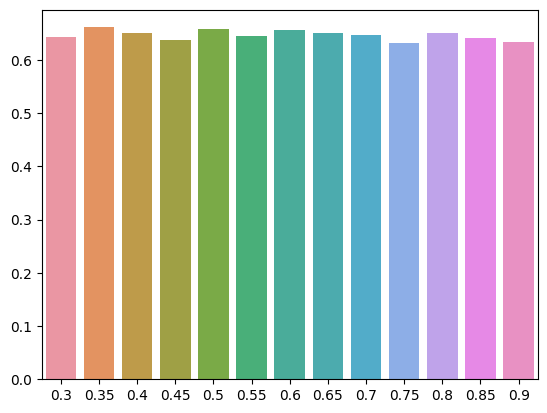

In [29]:
size = np.around(size, 3)
accuracy = np.around(accuracy, 3)
sns.barplot(x=size, y=accuracy)
plt.show()

# 4) Validação
## a) Nova função
Modifique a função criada anteriormente para que ela já separe a amostra em treino e teste, rode um modelo logístico e retorne alguma métrica de validação.

In [30]:
def full_logistic_regression(X, y, test_size=0.7):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    log_reg = LogisticRegression().fit(X_train, y_train)
    score = log_reg.score(X_test, y_test)
    return score

## b) Cross-validation
Use a função criada anteriormente para rodar 500 modelos logísticos em diferentes amostras de treino e de teste. Reporte os resultados desse exercício com um histograma dos valores de validação de alguma métrica.

In [31]:
accuracy = []
for i in range(1, 501):
    score = full_logistic_regression(X, y, test_size=0.7)
    accuracy.append(score)

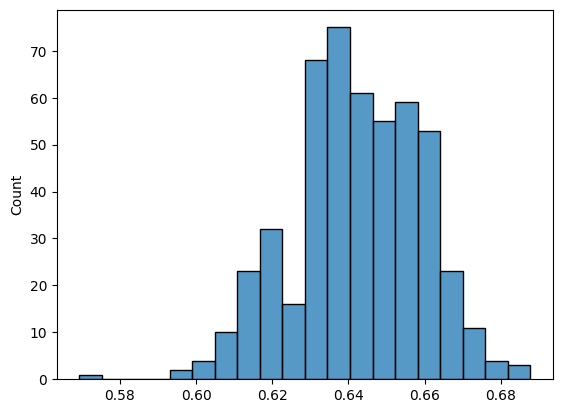

In [33]:
sns.histplot(accuracy)
plt.show()

# 5) Comparação de modelos
Adapte a função criada anteriormente para rodar um outro modelo de classificação binário, como naive bayes ou K-Nearest Neighbors (explore a documentação dos frameworks para descobrir outras opções e saber mais). Com esse novo modelo, rode 500 vezes e compare os resultados com o do modelo logístico criado anteriormente.